In [ ]:
# ===== 第一步：构造 H2 分子的费米子哈密顿量 =====
# 【物理意义】该步骤构造一个基于简化 H₂ 分子的电子哈密顿量。
# 使用 OpenFermion 表示费米子生成和湮灭算符，通过一体项和二体项描述动能、势能、电子关联。
# 这是从量子化学积分（如 Hartree-Fock 方法）中提取参数，用于量子算法测试与模拟。
# 用 OpenFermion 构造 H2 的费米子形式哈密顿量

from openfermion.ops import FermionOperator
from openfermion.transforms import bravyi_kitaev
from openfermion.utils import hermitian_conjugated
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# 构造 Toy Model 的费米子哈密顿量
H_f = FermionOperator('', -0.8126) # 常数项表示总能量基准
# 一体项：代表单电子能量贡献（动能、与核吸引）
H_f += FermionOperator('0^ 0', -0.0458)
H_f += FermionOperator('1^ 1', -0.0458)
H_f += FermionOperator('2^ 2', 0.1743)
H_f += FermionOperator('3^ 3', 0.1743)
# 二体项：代表电子-电子相互作用
H_f += FermionOperator('0^ 1^ 1 0', 0.1220)
H_f += FermionOperator('2^ 3^ 3 2', 0.1676)
H_f += FermionOperator('0^ 2^ 2 0', 0.1686)
H_f += FermionOperator('1^ 3^ 3 1', 0.1686)
H_f += FermionOperator('0^ 3^ 3 0', 0.1202)
H_f += FermionOperator('1^ 2^ 2 1', 0.1202)
# 非对角跃迁项（跃迁积分）
H_f += FermionOperator('0^ 2', -0.0450)
H_f += FermionOperator('1^ 3', -0.0450)
# 保证哈密顿量是厄米（Hermitian）：物理可观测必须满足此性质
H_f += hermitian_conjugated(H_f)


In [ ]:
# ===== 第二步：变换为 QubitOperator =====
# 【物理意义】将费米子哈密顿量映射到量子比特泡利算符表示。
# 这一步是模拟在量子计算机上的关键，使用 Bravyi-Kitaev 映射具有更紧凑的非局域特性。
# 使用 Bravyi-Kitaev 变换从 FermionOperator 得到泡利算符表示
H_q = bravyi_kitaev(H_f)

In [ ]:
# ===== 第三步：转换为 QuTiP 格式的 Qobj =====
# 【物理意义】将泡利哈密顿量转换为可用于动力学模拟的矩阵形式，基于张量乘积构建全系统哈密顿量。
n_qubits = 4
def qubit_operator_to_qutip(qubit_op, n_qubits):
    pauli_map = {'X': sigmax(), 'Y': sigmay(), 'Z': sigmaz()}
    H = 0
    for term, coeff in qubit_op.terms.items():
        ops = [qeye(2)] * n_qubits
        for idx, op in term:
            ops[idx] = pauli_map[op] # 将 Pauli 字符串变成 QuTiP 张量
        H += coeff * tensor(ops)
    return H
H_qubit = qubit_operator_to_qutip(H_q, n_qubits)

In [ ]:
# ===== 第四步：定义两个玻色子振动模系统 =====
# 【物理意义】简谐振子建模分子内部的核振动，自然对应玻色子。
# 两个模式代表两个自由度（如 H₂ 的对称和反对称伸缩），并存在耦合项模拟模间能量交换。
n_vib = 5
w1, w2 = 1.0, 1.2  # 两个模的频率
J = 0.1  # 模间耦合强度
a1 = destroy(n_vib)
a2 = destroy(n_vib)
H_vib = (
    w1 * tensor(a1.dag()*a1, qeye(n_vib)) +
    w2 * tensor(qeye(n_vib), a2.dag()*a2) +
    J * (tensor(a1.dag(), a2) + tensor(a1, a2.dag()))
)


In [ ]:
# ===== 第五步：构造电子-振动模耦合项 =====
# 【物理意义】电子态与核振动模的耦合，称为 vibronic coupling，是分子动力学不可或缺部分。
# 此处仅选择第一个 qubit（电子状态）和模1 耦合，耦合强度为 0.2
sigma_z = tensor(sigmaz(), qeye(2), qeye(2), qeye(2))
H_couple = tensor(sigma_z, tensor(a1 + a1.dag(), qeye(n_vib))) * 0.2

In [ ]:
# ===== 第六步：总哈密顿量构造 =====
# 【物理意义】系统总能量由电子、振动模、自身相互作用三部分构成。
# 使用张量乘积方式连接电子空间与玻色子空间。
I_q = tensor([qeye(2) for _ in range(n_qubits)])
I_b = qeye(n_vib)
I_bb = tensor(I_b, I_b)
H_tot = tensor(H_qubit, I_bb) + tensor(I_q, H_vib) + H_couple

In [ ]:
# ===== 第七步：设置初始态 psi0 =====
# 【物理意义】构造系统初态，假设电子系统处于全基态（|0000⟩），
# 振动模系统处于第一个模激发一次（|1⟩），第二个模在基态（|0⟩），形成非平衡初态用于能量传输研究。
psi_qubit = tensor([basis(2, 0) for _ in range(n_qubits)])
psi_boson = tensor(basis(n_vib, 1), basis(n_vib, 0))
psi0 = tensor(psi_qubit, psi_boson)

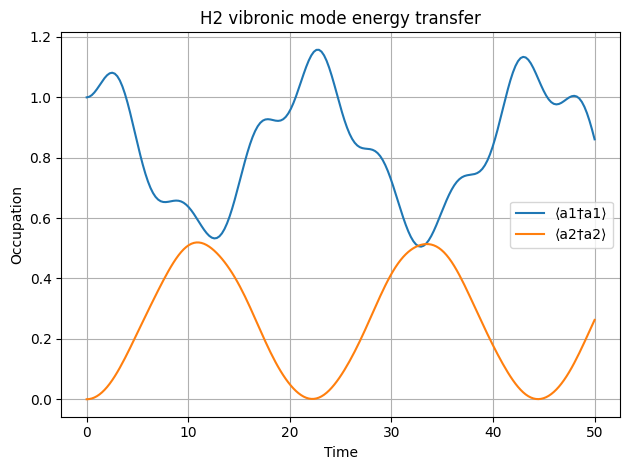

In [ ]:
# ===== 第八步：无耗散演化 =====
# 【物理意义】在不考虑环境耦合的情况下，观察系统在总哈密顿量 H_tot 驱动下的单位时间演化。
# 计算两个振动模随时间的激发数变化，反映模间能量交换。
tlist = np.linspace(0, 50, 200)
n1 = tensor(I_q, tensor(a1.dag() * a1, qeye(n_vib)))
n2 = tensor(I_q, tensor(qeye(n_vib), a2.dag() * a2))
result = mesolve(H_tot, psi0, tlist, [], [n1, n2])

plt.plot(tlist, result.expect[0], label="⟨a1†a1⟩")
plt.plot(tlist, result.expect[1], label="⟨a2†a2⟩")
plt.xlabel("Time")
plt.ylabel("Occupation")
plt.title("H2 vibronic mode energy transfer")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 这里横轴是时间，纵轴是激发数（即期望值⟨a†a⟩：表示每个模内的激发粒子数。蓝色线（⟨a1†a1⟩）：模1 的激发数，起始时为1，随着时间减小，说明能量在流出。橙色线（⟨a2†a2⟩）：模2 的激发数，起始为0，随时间上升，说明能量在流入。整体为周期性交替振荡，说明模1和模2在交换能量，即 声子或振动激发的量子跃迁与耦合。能量并非完全等幅交换（蓝色幅值始终大于橙色），可能由于初态不均衡或两个模频率不同（w1 ≠ w2）导致，即两个模的频率不同导致，呈现的是非耗散玻色子耦合系统的 Rabi 振荡现象。

#### 振荡现象：模1的激发数随时间减小，模2的激发数对应上升，对应量子系统中经典的激发子转移或能量交换过程，类似于两个耦合的摆，一个起始有能量，随着时间推移将能量周期性转移给另一个。

#### 周期性变化：模1和模2的occupation呈反向振荡，符合能量守恒。证明了模拟中的耦合项J[J * (a₁† a₂ + a₁ a₂†)哈密顿量片段（玻色子部分）]起到了实际“传递桥梁”的作用。周期由模频差和 J 强度共同决定，频率越接近、耦合越强，振荡越快、越均匀。

#### 结论：能量在两个振动模之间以量子方式转移，这是 vibronic 耦合（电子-振动耦合）核心机制。即使无外部激发，仅靠内部耦合结构就可实现模间量子相干能量共享；对研究分子光合作用、热输运、量子振动能量传递机制有直接意义。

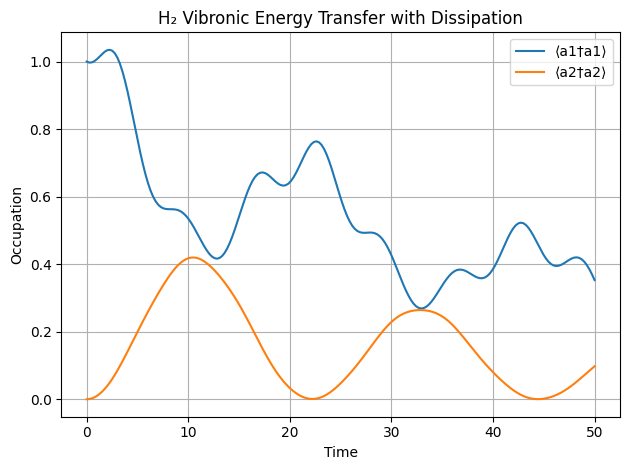

In [ ]:
# ===== 第九步：引入玻色子耗散 =====
# 此处模拟振动模系统与环境的相互作用，即开放量子系统的耗散机制。
# 耗散由 Linblad 主方程建模，collapse operators 表示能量流失通道。
# 模1和模2分别通过 a1, a2 与真空热浴相耦合。
gamma1 = gamma2 = 0.02 # 耗散速率
c_ops = [tensor(I_q, tensor(a1, I_b)) * np.sqrt(gamma1),
         tensor(I_q, tensor(I_b, a2)) * np.sqrt(gamma2)]
result = mesolve(H_tot, psi0, tlist, c_ops, [n1, n2])

plt.plot(tlist, result.expect[0], label="⟨a1†a1⟩")
plt.plot(tlist, result.expect[1], label="⟨a2†a2⟩")
plt.xlabel("Time")
plt.ylabel("Occupation")
plt.title("H₂ Vibronic Energy Transfer with Dissipation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### 加入耗散机制，模拟开放系统。模1、模2 分别以速率 $\gamma_1 = \gamma_2 = 0.02$与外部真空热浴耦合。
#### 模1（蓝色线 ⟨a1†a1⟩初始时刻激发数为 1，随后迅速整体下降，但仍存在振荡。振荡幅度不断减弱，出现指数式衰减趋势。表明模1 向外部环境持续释放能量（耗散作用）。
#### 模2（橙色线 ⟨a2†a2⟩）：随着模1 向其传递能量，模2 激发上升，但也随时间下降。同样存在有阻尼的振荡，并没有像无耗散图中那样持续上升再返回。
#### 模1 和模2 仍存在 J 耦合交换机制；同时，两个模也在向环境以速率$\gamma$泄漏激发子；系统中的总激发数不守恒（非厄米演化），这是开放系统的特征；能量先从模1 流向模2，然后逐步耗散到环境中。
#### 结论：耗散对振动模能量转移的抑制作用：系统激发态寿命有限；能量不可逆地流入环境。

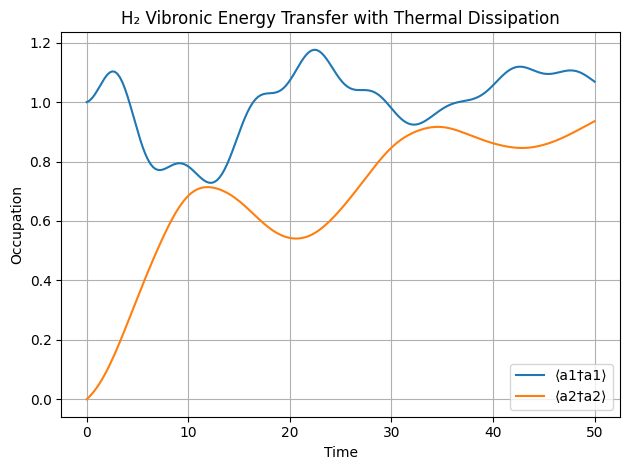

In [ ]:
# ===== 第十步：加入热耗散项（非零温度） =====
# 【物理意义】更现实的环境中存在热激发（T > 0），
# 环境不仅能吸收系统能量（a），也可将能量回馈给系统（a†），形成双向热交换。
# 热浴激发数 n_th 控制系统与环境之间的能量流动强度。
n_th = 1.5 # 平均热激发数（Bose-Einstein 分布）
c_ops = [
    np.sqrt(gamma1 * (n_th + 1)) * tensor(I_q, tensor(a1, I_b)), # 向环境衰减（spontaneous/emission）
    np.sqrt(gamma1 * n_th)       * tensor(I_q, tensor(a1.dag(), I_b)), # 从环境吸收能量（stimulated absorption）
    np.sqrt(gamma2 * (n_th + 1)) * tensor(I_q, tensor(I_b, a2)),
    np.sqrt(gamma2 * n_th)       * tensor(I_q, tensor(I_b, a2.dag())),
]
result = mesolve(H_tot, psi0, tlist, c_ops, [n1, n2])

plt.plot(tlist, result.expect[0], label="⟨a1†a1⟩")
plt.plot(tlist, result.expect[1], label="⟨a2†a2⟩")
plt.xlabel("Time")
plt.ylabel("Occupation")
plt.title("H₂ Vibronic Energy Transfer with Thermal Dissipation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 平均热激发数：n_th = 1.5，即热环境中存在一定数目的激发子（热声子）。模1 与模2 同时与热浴发生双向耦合：向环境辐射（spontaneous emission）；从环境吸收（stimulated absorption），总系统仍为振动模 + 环境的 Lindblad 演化。
####  模1（蓝色线 ⟨a1†a1⟩）：初始有激发，先出现下降但随后持续维持在高水平（~1）附近；说明模1 虽然发生能量耗散，但不断从环境吸收热激发子，达到某种准稳态；振荡幅度减小，趋向“热平衡”。
####  模2（橙色线 ⟨a2†a2⟩）：初始为 0，迅速上升至接近 0.8，显示激发子从模1 和热环境同时流入；此后也保持在高水平并缓慢波动；表明热环境维持系统激发数量，不再出现“逐步衰减”。
#### 结论：引入热耗散使系统不再耗尽激发态，而是趋于热平衡态（非零激发）；能量不仅从模1 传递到模2，也可以从环境流入系统；这是热浴与量子系统相互作用的典型行为（Bose-Einstein 热注入）。

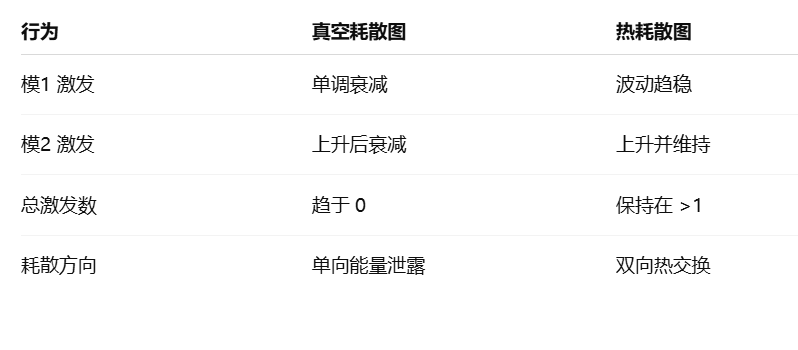

In [ ]:
# ===== 第十一步：系统参数扫描模拟不同热激发下的演化（含电子退相干） =====
# 【物理意义】系统性探索不同热激发条件（n_th）下振动模能量流动行为。
# 额外加入电子系统的退相干路径（例如激发态衰减或横向退相干），模拟电子与环境耦合引起的 decoherence。
# 用于理解热环境如何改变电子-声子耦合动力学。
# 展示系统在冷环境、热环境、强退相干环境下的响应差异，有助于理解量子系统对热背景的鲁棒性与敏感性。
results = {}
for n_th in [0.0, 0.5, 1.5, 3.0, 6, 12]:
    c_ops = [
        np.sqrt(gamma1 * (n_th + 1)) * tensor(I_q, tensor(a1, I_b)),
        np.sqrt(gamma1 * n_th)       * tensor(I_q, tensor(a1.dag(), I_b)),
        np.sqrt(gamma2 * (n_th + 1)) * tensor(I_q, tensor(I_b, a2)),
        np.sqrt(gamma2 * n_th)       * tensor(I_q, tensor(I_b, a2.dag())),# 添加电子退相干通道：模拟一个 qubit 的能量 T1 弛豫过程（如激发→基态）
        np.sqrt(0.01) * tensor(sigmax(), qeye(2), qeye(2), qeye(2), I_bb),
    ]
    res = mesolve(H_tot, psi0, tlist, c_ops, [n1, n2])
    results[n_th] = res.expect

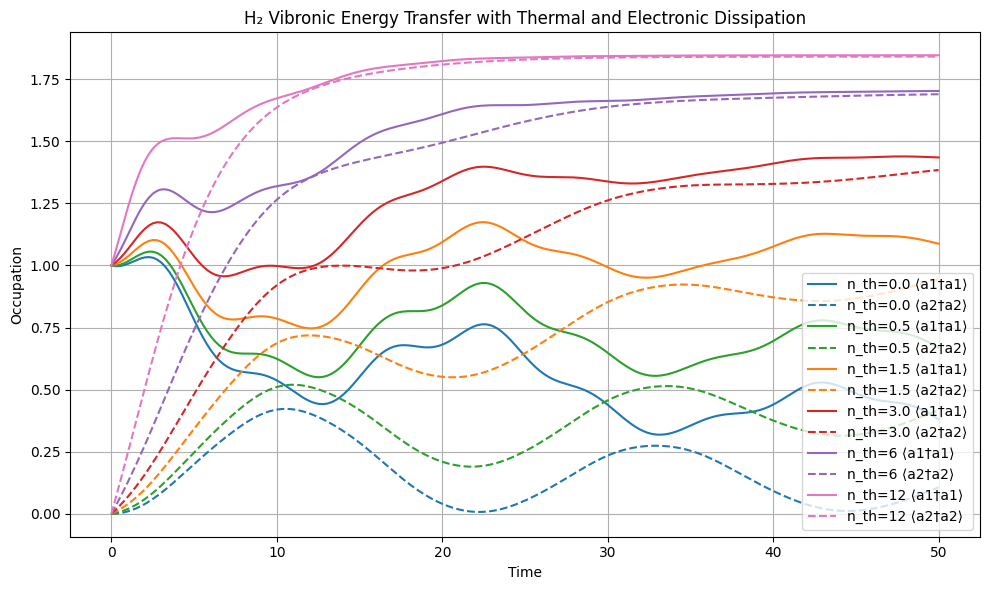

In [ ]:
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple', 'tab:pink']
plt.figure(figsize=(10, 6))
for idx, (n_th, expect) in enumerate(results.items()):
    plt.plot(tlist, expect[0], linestyle='-', color=colors[idx], label=f'n_th={n_th} ⟨a1†a1⟩')
    plt.plot(tlist, expect[1], linestyle='--', color=colors[idx], label=f'n_th={n_th} ⟨a2†a2⟩')

plt.xlabel("Time")
plt.ylabel("Occupation")
plt.title("H₂ Vibronic Energy Transfer with Thermal and Electronic Dissipation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 在不同热激发水平n_th下，H₂分子振动模之间的能量转移行为，并同时考虑电子退相干机制。
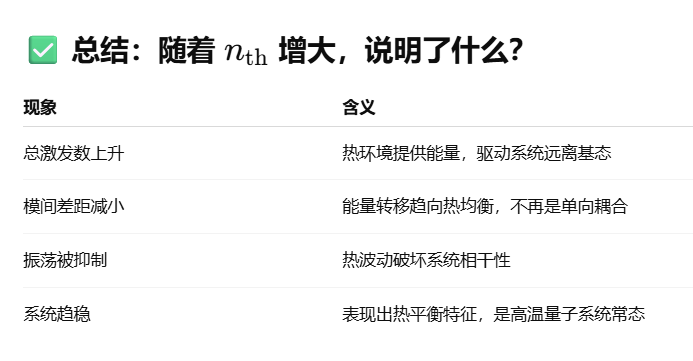